# Introducció
L'objectiu d'aquesta pràctica és aplicar tots els coneixements adquirits en l'assignatura impartida d'aprenentatge computacional en l'anàlisi d'un dataset determinat (en el meu cas en el dataset de churn_risk_score). S'han utilitzat múltiples llibreries, com pandas, sklearn, numpy, seaborn...

# Dataset
Tal i com ja s'ha comentat, he utilitzat el dataset de Churn Risk Score (el link per descargar-se el dataset és el següent: https://www.kaggle.com/imsparsh/churn-risk-rate-hackerearth-ml).

Cap empresa pot prosperar sense els clients; per tant, com més clients abandonin el negoci, pitjor és el futur d'aquest.
De fet, una de les mètriques clau per mesurar l'èxit d'una empresa és mesurar la seva taxa de rotació de clients: com més baix sigui, més estimada serà l'empresa. Així doncs, segons el nostre dataset, com més clients tinguin un valor baix de churn_risk_score, millor anirà l'empresa.

L'objectiu és predir la puntuació del risc d'abandonament per a un lloc web basat en el conjunt de dades. Els valors de la puntuació són entre 1 i 5.

Les columnes són:
customer_id, Name, age, gender, security_no, region_category, membership_category, joining_date, joined_through_referral, referral_id, preferred_offer_types, medium_of_operation, internet_option, last_visit_time, days_since_last_login, avg_time_spent, avg_transaction_value, avg_frequency_login_days, points_in_wallet, used_special_discount, offer_application_preference, past_complaint, complaint_status, feedback, churn_risk_score

El dataset consta de dos fixers, un és per entrenar els classificadors (train.csv) i l'altre és per predir el churn_risk_score (test.csv).

Primer importem les llibreries necessàries

In [1]:
import pandas as pd
from sklearn import preprocessing  
from sklearn import metrics
import seaborn as sns
from sklearn import tree
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import math

In [2]:
#Per canvi de número de components
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

#Provarem la regressió lineal
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

#Diferents models classificadors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

#Per cross-validar les dades
from sklearn import metrics
from sklearn.model_selection import cross_val_score

#Per fer la roc-curve
from sklearn.preprocessing import label_binarize
from sklearn.datasets import make_classification
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import roc_curve

from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args

from skopt import gp_minimize
from skopt.plots import plot_convergence
from sklearn.model_selection import HalvingGridSearchCV

from wordcloud import WordCloud

# Dataset
Primer carraguem les dades, canviem a numèric i les filtrem

In [4]:
def load_dataset(path):
    dataset = pd.read_csv(path, header=0, delimiter=',')
    return dataset

# Primer carreguem dataset d'exemple
dataset_train = load_dataset('train.csv')
data_train = dataset_train.values
dataset_test = load_dataset('test.csv')
data_test = dataset_test.values

#Les columnes 'Name', 'referral_id', 'security_no', 'customer_id' són irrellevants
dataset_train = dataset_train.drop(['Name', 'referral_id', 'security_no', 'customer_id'], axis=1)  # dropping unnecessary columns 

#Definim el número depenent de la 'magnitud' (ex: village és més petit que town i town és més petit que city o silver membership 
#és una categoria inferior a gold membership)
dataset_train = dataset_train.replace({"No Membership": 0, "Basic Membership": 1, "Silver Membership": 2, "Gold Membership": 3, "Platinum Membership": 3, "Premium Membership": 5})
dataset_train = dataset_train.replace({"Village": 0, "Town": 1, "City": 2})
#dataset per fer un plot en concret, que es necessiten les dades sense codificar
feed = dataset_train
feed = feed[feed['churn_risk_score'] != -1]
#Aquesta ordenació ha estat observant quins missatges són més recorrents en cada etiqueta (codi més abaix)
dataset_train = dataset_train.replace({
 'No reason specified': 0,
 'Poor Website': 1,
 'Poor Product Quality': 2,
 'Poor Customer Service': 3,
 'Too many ads': 4,
 'Reasonable Price': 5,
 'Products always in Stock': 6, 
'Quality Customer Care': 7,
'User Friendly Website': 8 })

#descartem els valors nulls i els valors on churn_risk score és -1 
df_primer = dataset_train.dropna()
df_primer = df_primer[df_primer['churn_risk_score'] != -1]

#Fem els mateixos canvis pel test
dataset_test = dataset_test.drop(['Name', 'referral_id', 'security_no', 'customer_id'], axis=1)  # dropping unnecessary columns 
dataset_test = dataset_test.replace({"No Membership": 0, "Basic Membership": 1, "Silver Membership": 2, "Gold Membership": 3, "Platinum Membership": 3, "Premium Membership": 5})
dataset_test = dataset_test.replace({"Village": 0, "Town": 1, "City": 2})
dataset_test = dataset_train.replace({
 'No reason specified': 0,
 'Poor Website': 1,
 'Poor Product Quality': 2,
 'Poor Customer Service': 3,
 'Too many ads': 4,
 'Reasonable Price': 5,
 'Products always in Stock': 6, 
'Quality Customer Care': 7,
'User Friendly Website': 8 })

#dataset_test = dataset_test.replace({np.nan: -1})

df2_primer = dataset_test.dropna()

label_encoder = preprocessing.LabelEncoder()
a = df_primer.columns

#es codifica la resta de valors que són strings
for i in a[:-1]:
    if(type(df_primer[i][0]) == str):
        df_primer[i] = df_primer[i].astype('|S')
        df_primer[i] = label_encoder.fit_transform(df_primer[i])
        df2_primer[i] = df2_primer[i].astype('|S')
        df2_primer[i] = label_encoder.fit_transform(df2_primer[i])


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [276]:
X = df_primer.iloc[:,:-1]
y = df_primer['churn_risk_score']
x_t, x_v, y_t, y_v = train_test_split(X, y, train_size=0.3)

Mirem si el dataset està balancejat. Com que no està balancejat, per avaluar els models de classificació, es farà servir el cross_validation_score.

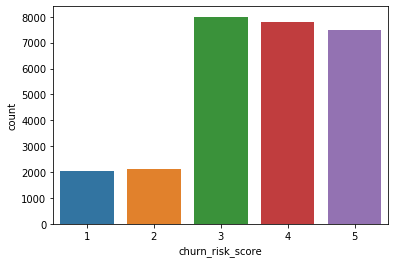

In [307]:
g = sns.countplot(y)
g.set_xticklabels(list(set(y)))
plt.show()

El codi següent ha servit per veure quin feedback era més recorrent per cada etiqueta i per tant per poder remplaçar correctament tots els valors


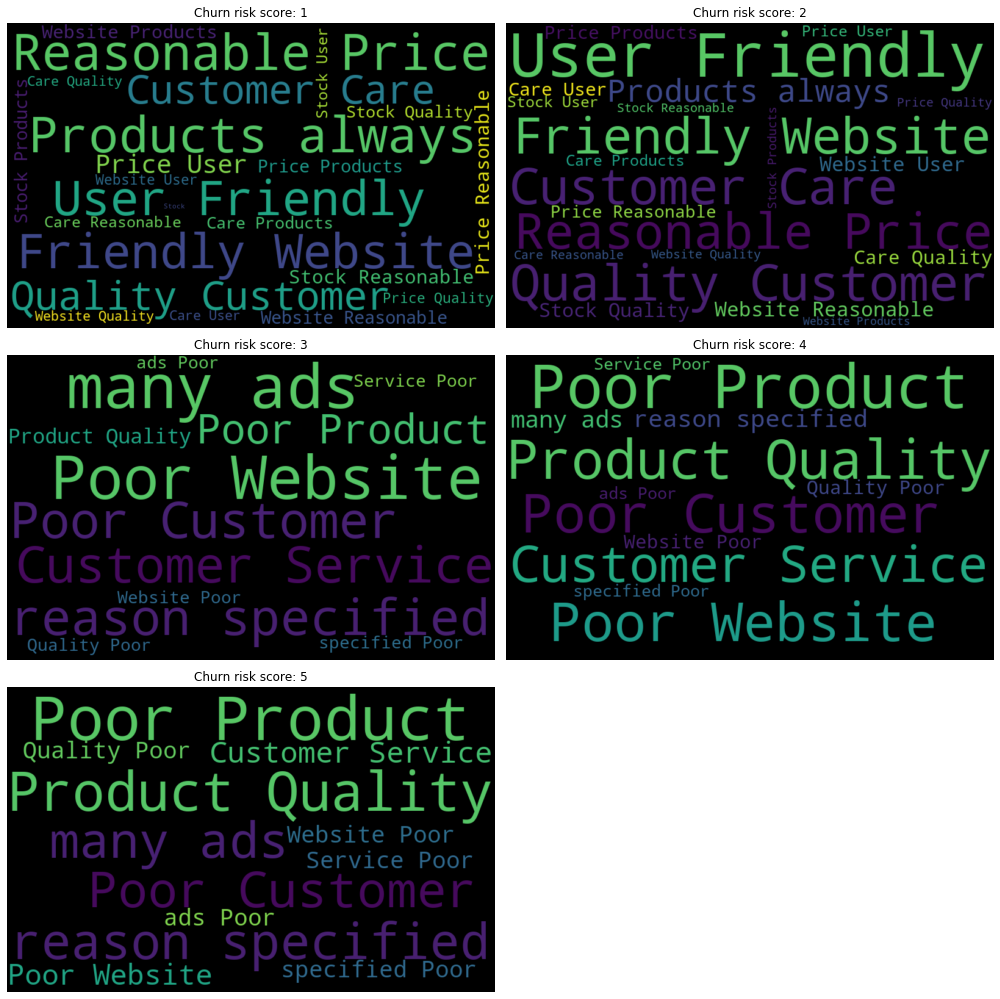

In [25]:
fig = plt.figure(figsize=(14,14))

a = 3  
b = 2  
c = 1  

#fig, axs = plt.subplots(3, 2)
j = 0
for i in list(set(feed['churn_risk_score'])):
    plt.subplot(a, b, c)
    plt.xlabel(i)
    plt.title('Churn risk score: {}'.format(i))
    all_words = " ".join(sent for sent in feed['feedback'][feed['churn_risk_score'] == i])
    wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    c = c+1
fig.tight_layout()
plt.show()

# NORMALIZE
He intentat normalitzar les dades, però després he vist que es classifica pitjor si es normalitzen.

In [13]:
prepoc_data = X.drop(columns =['gender', 'used_special_discount', 'offer_application_preference', 'past_complaint'], axis=1)
a = prepoc_data.columns
dataset_train_numeric_columns = preprocessing.normalize(prepoc_data)
dataset_train_numeric_columns = pd.DataFrame(dataset_train_numeric_columns, columns = a)
dataset_train_binary_columns = pd.DataFrame(X, columns = ['gender', 'used_special_discount', 'offer_application_preference', 'past_complaint'])
dataset_train_normalized = pd.concat([dataset_train_numeric_columns, dataset_train_binary_columns, y], axis = 1)
#dataset_train_normalized

# Correlació
Mirem la correlació de tots els atributs amb el 'churn_risk_score' per tal d'agafar els més significatius a l'hora de fer-los servir pels models classificadors.

age                             0.002941
gender                         -0.002138
region_category                 0.032802
membership_category            -0.729634
joining_date                    0.014008
joined_through_referral         0.028981
preferred_offer_types           0.038346
medium_of_operation             0.019133
internet_option                -0.000521
last_visit_time                -0.012992
days_since_last_login          -0.006270
avg_time_spent                 -0.023063
avg_transaction_value          -0.366336
avg_frequency_login_days       -0.035976
points_in_wallet               -0.329597
used_special_discount          -0.009373
offer_application_preference   -0.041596
past_complaint                  0.014431
complaint_status                0.005599
feedback                       -0.573446
churn_risk_score                1.000000
Name: churn_risk_score, dtype: float64

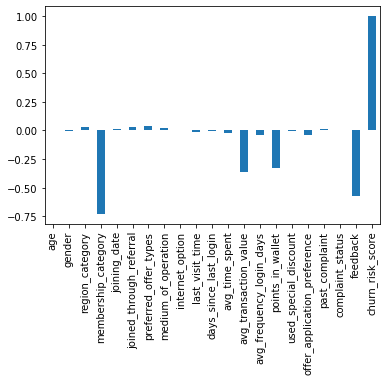

In [12]:
correlacio = df_primer.corr()
correlacio['churn_risk_score'].plot(kind='bar')
correlacio['churn_risk_score']
#mes correlacio: membership_category, points_in_wallet, feedback, customer_id


In [9]:
#Mirem les correlacions més significatives

df_final = df_primer.dropna()
correlations = df_primer.corr()['churn_risk_score'].sort_values(ascending=False)
print(correlations[abs(correlations) > 0.2])


churn_risk_score         1.000000
points_in_wallet        -0.329597
avg_transaction_value   -0.366336
feedback                -0.573446
membership_category     -0.729634
Name: churn_risk_score, dtype: float64


Es pot veure com els atributs més significatius respecte l'etiqueta 'churn_risk_score' són: 'points_in_wallet', 'avg_transaction_value', 'feedback', 'membership_category' (tots tres indirectament proporcional (com millor member, menys score i com mes points menys abandonen).

Pairplot de les dades més significatives respecte churn_risk_score

In [14]:
j=df_primer[['points_in_wallet', 'avg_transaction_value', 'feedback', 'membership_category', 'preferred_offer_types', 'offer_application_preference', 'churn_risk_score']]

D:\Anaconda\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
D:\Anaconda\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


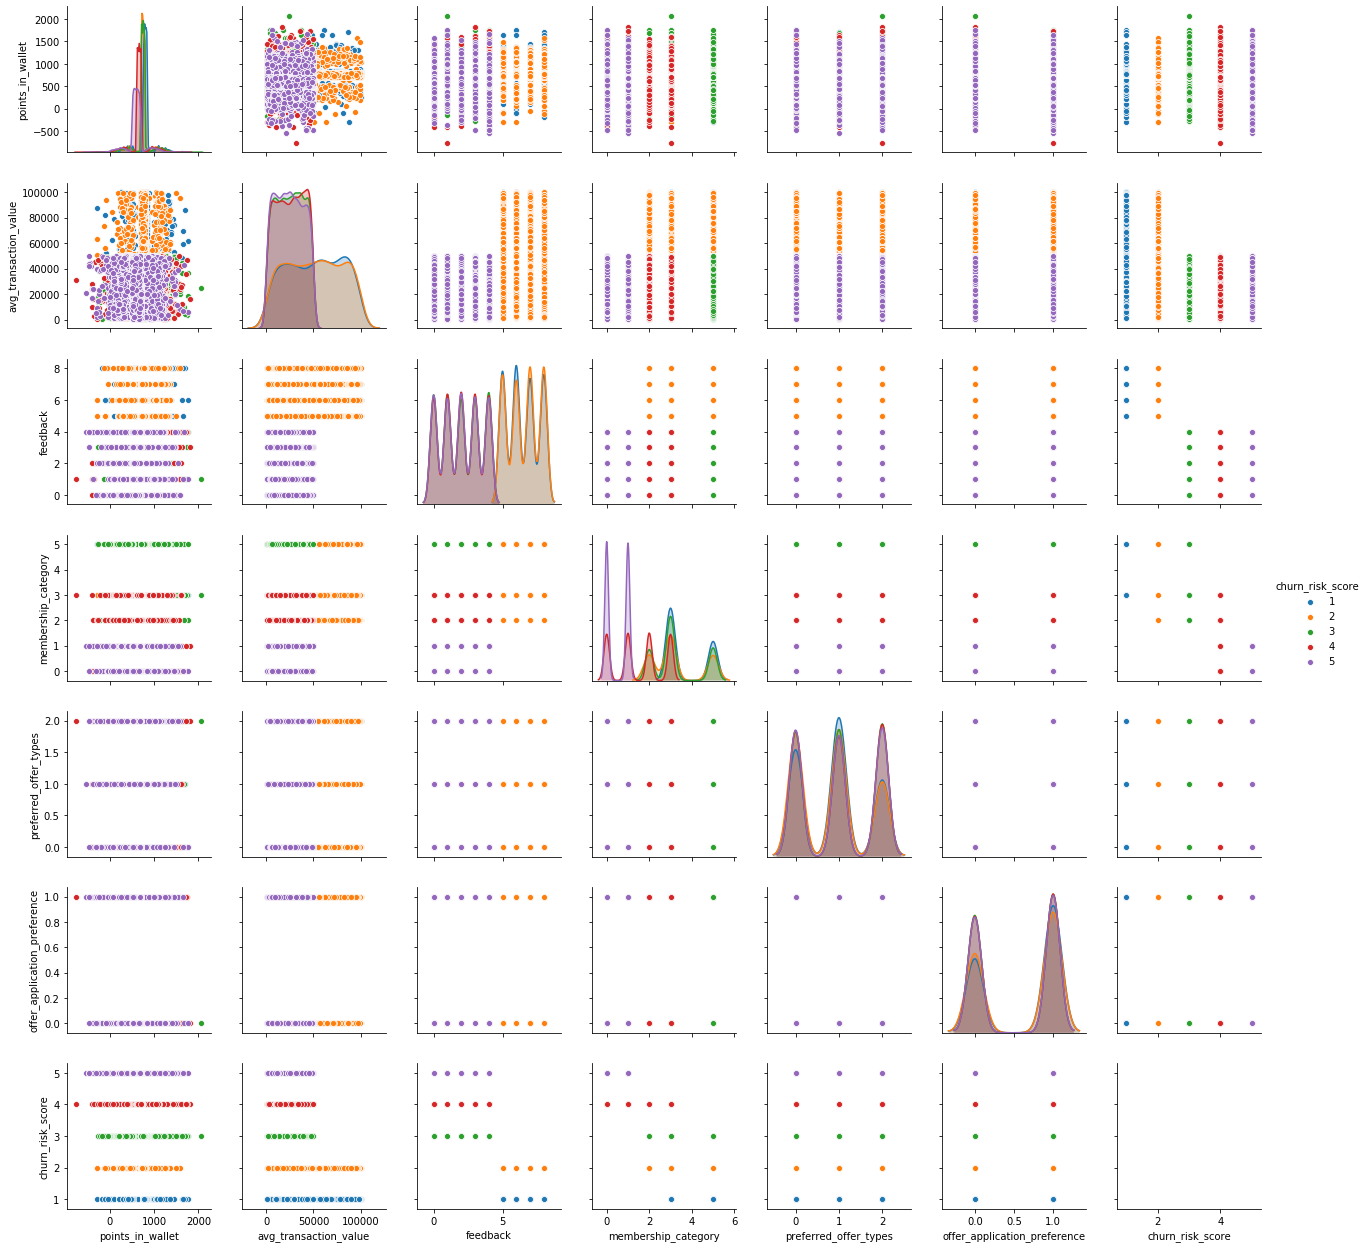

In [15]:
sns.pairplot(j, hue="churn_risk_score")

Amb aquest pairplot s'evidencia el que s'ha esmentat anteriorment. Es pot observar com les característiques amb més correlació amb l'etiqueta, en general prenen valors diferents per les diferentes puntuacions de churn risk, en canvi les que tenen menys correlació ('preferred_offer_types', 'offer_application_preference') es veu com prenen valors iguals independentment de l'etiqueta. No he trobat necessari fer-ho per tots els atributs, ja que no ens aportarà cap tipus d'informació extra.

Al següent gràfic es veu la correlaicó entre membership_category i el churn risk score

[Text(0.5, 1.0, 'Membership Category in Different churn risk score')]

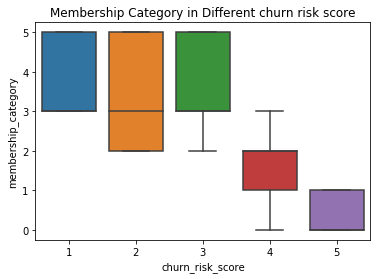

In [15]:
bp = sns.boxplot(x='churn_risk_score',y='membership_category', data=df_primer)
bp.set(title="Membership Category in Different churn risk score")

# Canvis de dimensionalitat
Per veure com afecten els canvis de dimensionalitat i com es veu respecte l'etiqueta, ho he fet amb PCA, 

No he aplicat ni TSNE ni ISOMAP perquè ambdos triguen molt temps a executar-se, ja que funcionen bé per datasets petits, però el que estem avaluant és massa gran.
A part també he aplicat TruncatedSVD i LDA

## PCA

Fer més coses amb PCA!
A continuació es pot veure com no funciona gaire bé la PCA amb 2 components (mirar a partir de quants esta be)

In [379]:
X = df_final[['membership_category', 'feedback', 'avg_transaction_value', 'points_in_wallet']]
y = df_primer['churn_risk_score']
x_t, x_v, y_t, y_v = train_test_split(X, y, train_size=0.3)

suma: 0.9999999842365624
[9.99901547e-01 9.84372154e-05 1.06514692e-08 5.11196820e-09]


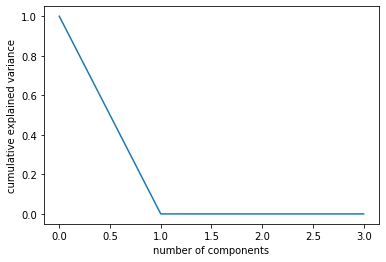

In [388]:
pca=PCA(n_components=X.shape[1]) 
pca.fit(X) 
X_pca=pca.transform(X) 
 
expl = pca.explained_variance_ratio_
print('suma:',sum(expl[0:2]))
print(expl)
plt.plot((pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()


Es pot veure com amb 1 component ja n'hi ha prou, tot i així, per visualitzar-ho correctament, ho farem amb 2.

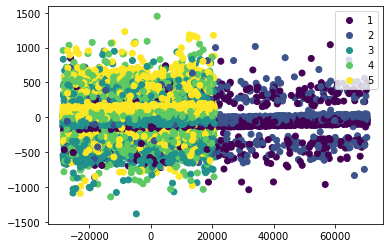

In [371]:
target = df_final['churn_risk_score'].to_numpy()
pca = PCA(n_components=2)
result=pca.fit(X)

result_plt=pca.fit_transform(X)
plot = plt.scatter(result_plt[:,0],result_plt[:,1], c=df_final['churn_risk_score'])
plt.legend(handles=plot.legend_elements()[0], labels=list(set(df_final['churn_risk_score'])))


## TSNE 

El t-SNE té una funció de cost que no és convexa, és a dir, amb diferents inicialitzacions podem obtenir resultats diferents.En el nostre cas, aquesta funció va moolt lenta perque hi ha moltes dades, per tant és millor utilitzar PCA o TruncatedSVD

## TruncatedSVD

0.9999999841396588


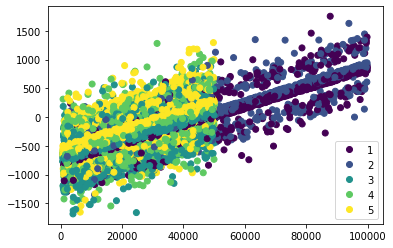

In [387]:
svd = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
trunc = svd.fit(X)
res= trunc.explained_variance_ratio_
print(sum(res[0:2]))
trunc = svd.fit_transform(X)
plot = plt.scatter(trunc[:,0],trunc[:,1], c=df_final['churn_risk_score'])
plt.legend(handles=plot.legend_elements()[0], labels=list(set(df_final['churn_risk_score'])))


# LDA

0.7510745889340233


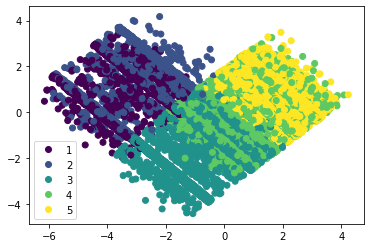

In [389]:
lda = LDA(n_components=2)
lda.fit(X, y)
res= lda.explained_variance_ratio_
print(sum(res[0:1]))
result = lda.fit_transform(X, df_final['churn_risk_score'])
plot = plt.scatter(result[:,0],result[:,1], c=df_final['churn_risk_score'])
plt.legend(handles=plot.legend_elements()[0], labels=list(set(df_final['churn_risk_score'])))

Es pot veure com el PCA funciona molt millor respecte els altres dos classificadors, tot i així està molt a la par amb TruncatedSVD. El que és menys útil és LDA.

# Models de classificació

S'han utilitzat diferents models, tant lineals com no lineals.
Aquí es divideix el dataset train en un per entrenar el classificador i l'altre per avaluar-lo. Un 30% de les dades totals seran per avaluar

In [173]:
X = df_final[['membership_category', 'feedback', 'avg_transaction_value', 'points_in_wallet']]
y = df_final['churn_risk_score']
x1_t, x1_v, y1_t, y1_v = train_test_split(X1, y1, train_size=0.3)

## Linear Regression


Primer s'ha aplicat la regressió lienal, primer amb un model lineal (polinomi de grau 1) i després amb polinomis fins a grau 10 per veure quin és el millor. Es pot veure com el que té més bon accuracy és el de grau 3, que és de 0.567, tot i així, tal i com es veurà més endavant, no és el millor resultat; així doncs, com ja s'esperava, serà millor utilitzar un model no-lineal.

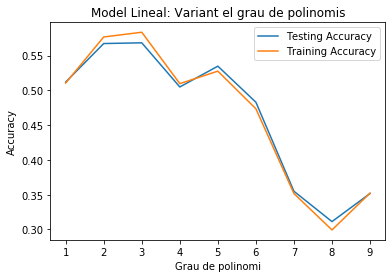

Màxim accuracy:  0.5684571785138578  amb el polinomi de grau  3


In [71]:
test_accuracy = list()
train_accuracy = list()
max_acc = 0
for i in range(1, 10):
    poly = PolynomialFeatures(i)
    X_poly=poly.fit_transform(x1_t)
    X_poly_v=poly.fit_transform(x1_v)

    reg = LinearRegression().fit(X_poly, y1_t)
    pred_train = reg.predict(X_poly)
    pred_test = reg.predict(X_poly_v)
    
    #Com que churn_rsik_score és en format int i no float, aproximem el resultat perquè sigui int i així poder calcular 
    #correctament l'accuracy
    pred_train = pred_train.round(0).astype(int)
    pred_test = pred_test.round(0).astype(int)
    
    accur = accuracy_score(y1_v, pred_test)

    train_accuracy.append(accuracy_score(y1_t, pred_train))
    test_accuracy.append(accur)
    if(accur > max_acc):
        max_acc = accur
        it = i
    
plt.title('Model Lineal: Variant el grau de polinomis')
plt.plot(list(range(1,10)), test_accuracy, label = 'Testing Accuracy')
plt.plot(list(range(1,10)), train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Grau de polinomi')
plt.ylabel('Accuracy')
plt.show()
print('Màxim accuracy: ', max_acc, ' amb el polinomi de grau ', it)

## Models no lineals

### KNeighbors, GaussianNB, SGD, DecisionTree, RandomForest, LightLGBM, GradientBoostingRegressor

Primer mirem diferents models per tal de veure quins són els millors. No s'utilitza cap de tipus SVC ja que triga molt de temps a executar-se, i no dóna gaire bon rendiment comparat amb algun altre model dels que s'avaluen a continuació.

In [174]:
def show_C_effect(X, y):
    titles = ('KNeighborsClassifier',
              'GaussianNB',
              'SGDClassifier',
              'DecisionTreeClassifier',
             'RandomForestClassifier',
              'LightGBMClassifier',
             'GradientBoostingRegressor'
             )
    models1 = (KNeighborsClassifier(n_neighbors=6) ,
             GaussianNB(),
             SGDClassifier(loss="modified_huber", max_iter = 10000),
             DecisionTreeClassifier(max_depth = 10, random_state = 101, max_features = None, min_samples_leaf = 15),
             RandomForestClassifier(),
             lgb.LGBMClassifier(),
               GradientBoostingRegressor(n_estimators=50, random_state=0)
              )
    models = (clf.fit(X, y) for clf in models1)
    
    score = (cross_val_score(clf, X, y, cv=8).mean() for clf in models)
    for sc, tlt in zip(score, titles):
        print('Score in ', tlt, ' is ', sc)

In [175]:
show_C_effect(X, y)

Score in  KNeighborsClassifier  is  0.5942414094350612
Score in  GaussianNB  is  0.635956610366919
Score in  SGDClassifier  is  0.22888759464181713
Score in  DecisionTreeClassifier  is  0.792770821199767
Score in  RandomForestClassifier  is  0.7864370995923121
Score in  LightGBMClassifier  is  0.7916788002329644
Score in  GradientBoostingRegressor  is  0.9141690950516346


Veiem com el millor classificador sens dubte és GradientBoostingRegressor. Els altres que també funcionen força bé són LightGBM, DecisionTreeClassifier i RandomForestClassifier, per tant són els que intentaré optimitzar per tal d'aconseguir el màxim rendiment. Tot i així tastejem el KNeighbours per diferent nombre de veïns i veiem com el rendiment no millora, per tant ja no el tindrem en conta.

Preliminary model score:
0.5978450786255096
Final model score:
0.5998835177635411


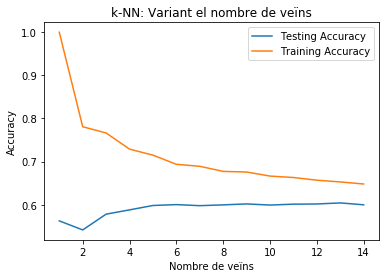

In [74]:
knn = KNeighborsClassifier(n_neighbors=2)  
#knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(X_t,y_t)

print("Preliminary model score:")
print(knn.score(X_v,y_v))

no_neighbors = np.arange(2, 15)
train_accuracy = np.empty(len(no_neighbors))
test_accuracy = np.empty(len(no_neighbors))

for i, k in enumerate(no_neighbors):
    # We instantiate the classifier
    knn = KNeighborsClassifier(n_neighbors=k)
    # Fit the classifier to the training data
    knn.fit(X_t,y_t)
    # Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_t, y_t)
    # Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_v, y_v)

# Visualization of k values vs accuracy
print("Final model score:")
print(knn.score(X_v,y_v))

plt.title('k-NN: Variant el nombre de veïns')
plt.plot(no_neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(no_neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Nombre de veïns')
plt.ylabel('Accuracy')
plt.show()

Es mira si serveix fer 'PolynomialFeatures' i es veu com el valor de l'accuracy no canvia gaire respecte sense fer aqeust canvi, per tant ja no l'utilitzem. (dóna més o menys el mateix accuarcy per polinomis de diferents graus)

In [89]:
j = df_final[['membership_category', 'feedback', 'avg_transaction_value', 'points_in_wallet']]
X1 = j
y1 = df_final['churn_risk_score']
X_t, X_v, y_t, y_v = train_test_split(X1, y1, train_size=0.3)

poly = PolynomialFeatures(2)
X_poly=poly.fit_transform(x1_t)
X_poly_v=poly.fit_transform(x1_v)


clf = DecisionTreeClassifier(max_depth = 10, random_state = 101, max_features = None, min_samples_leaf = 15)
clf = clf.fit(X_poly,y1_t)

pred = clf.predict(X_poly_v)
score = clf.score(X_poly_v, y1_v)
score

0.7874785502573969

# Optimització de paràmetres

Ara toca optimitzar paràmetres, mirarem si optimitzant algun dels 3 models que donen el segon accuarcy tenim més bon resultat que anteriorment. Si no és així, ens centrarem únicament en GradientBoostingRegressor.

S'han utilitzat les funcions HalvingGridSearchCV (semblant a GridSearchCV però per datasets grans) i gp_minimize. Aquesta última s'ha fet servir per l'algoritme de GradientBoostingRegresor ja que funciona molt bé per aquest i el de HalvingGridSearchCV pels altres tres models esmentats anteriorment.

No s'ha utilitzat BayesSearchCV, GridSearchCV ja que triguen massa

### DecisionTreeClassifier

In [156]:
param_grid = {'max_depth': [3, 5, 10, 15, 20],
               'min_samples_split': [10, 15, 20, 25],
             'random_state': [50, 100, 150, 200],
             'min_samples_leaf': [15, 20, 25, 30]}
base_estimator = DecisionTreeClassifier()
sh = HalvingGridSearchCV(base_estimator, param_grid, cv=5,
                          factor=2, max_resources=100).fit(X, y)
sh.best_estimator_

DecisionTreeClassifier(max_depth=5, min_samples_leaf=15, min_samples_split=10,
                       random_state=150)

In [157]:
clf = DecisionTreeClassifier(max_depth = sh.best_params_['max_depth'], min_samples_leaf=sh.best_params_['min_samples_leaf'], 
                             min_samples_split=sh.best_params_['min_samples_split'], random_state = sh.best_params_['random_state'])
clf = clf.fit(X,y)
scores = cross_val_score(clf, X, y, cv=5)
print(scores.mean())
print(scores.std())

0.7971757162168474
0.004693996178108046


### RandomForestClassifier

In [158]:
param_grid = {'max_depth': [3, 5, 10, 15, 20],
               'min_samples_split': [10, 15, 20, 25],
             'random_state': [50, 100, 150, 200],
             'min_samples_leaf': [15, 20, 25, 30],
             }
base_estimator = RandomForestClassifier()
sh = HalvingGridSearchCV(base_estimator, param_grid, cv=5,
                          factor=2, max_resources=100).fit(X, y)
sh.best_estimator_

RandomForestClassifier(max_depth=5, min_samples_leaf=15, min_samples_split=20,
                       random_state=150)

In [159]:
clf = RandomForestClassifier(max_depth = sh.best_params_['max_depth'], min_samples_leaf=sh.best_params_['min_samples_leaf'], 
                             min_samples_split=sh.best_params_['min_samples_split'], random_state = sh.best_params_['random_state'])
clf = clf.fit(X,y)
scores = cross_val_score(clf, X, y, cv=5)
print(scores.mean())
print(scores.std())

0.7899681578348521
0.0025504022430250534


### LGBMClassifier

In [162]:
param_grid = { 'max_depth': [3, 5, 10, 15, 20],
              'min_child_samples': [15, 20, 25, 30],
             'n_estimators': [100, 150, 200],
              'num_leaves': [20, 30, 40]
             }
base_estimator = lgb.LGBMClassifier()
sh = HalvingGridSearchCV(base_estimator, param_grid, cv=5,
                          factor=2, max_resources=100).fit(X, y)
sh.best_estimator_

LGBMClassifier(max_depth=3, min_child_samples=15, num_leaves=40)

In [316]:
clf = LGBMClassifier(max_depth=3, min_child_samples=15, num_leaves=40)
clf = clf.fit(X,y)
scores = cross_val_score(clf, X, y, cv=5)
print(scores.mean())
print(scores.std())

0.8031454017336473
0.004799026617090186


### GradientBoostingRegressor

In [140]:
n_features = X_t.shape[1]

# gradient boosted trees tend to do well on problems like this
reg = GradientBoostingRegressor(n_estimators=50, random_state=0)


# The list of hyper-parameters we want to optimize. For each one we define the
# bounds, the corresponding scikit-learn parameter name, as well as how to
# sample values from that dimension (`'log-uniform'` for the learning rate)
space  = [Integer(5, 20, name='max_depth'),
          Real(10**-5, 10**0, "log-uniform", name='learning_rate'),
          Integer(1, n_features, name='max_features'),
          Integer(2, 100, name='min_samples_split'),
          Integer(1, 100, name='min_samples_leaf')]

# this decorator allows your objective function to receive a the parameters as
# keyword arguments. This is particularly convenient when you want to set
# scikit-learn estimator parameters
@use_named_args(space)
def objective(**params):
    reg.set_params(**params)

    return -np.mean(cross_val_score(reg, X, y, cv=5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

In [141]:
res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

print("""Best parameters:
- max_depth=%d
- learning_rate=%.6f
- max_features=%d
- min_samples_split=%d
- min_samples_leaf=%d""" % (res_gp.x[0], res_gp.x[1], res_gp.x[2],
                            res_gp.x[3], res_gp.x[4]))

Best parameters:
- max_depth=15
- learning_rate=0.092438
- max_features=4
- min_samples_split=100
- min_samples_leaf=1


In [308]:
clf = GradientBoostingRegressor(n_estimators=50, random_state=0, max_depth = res_gp.x[0], learning_rate = res_gp.x[1],
                                max_features = res_gp.x[2], min_samples_split = res_gp.x[3], min_samples_leaf = res_gp.x[4])
model_final = clf
clf = clf.fit(X,y)
pred = clf.predict(x_v)
acc = accuracy_score(pred.round(0).astype(int), y_v)
print(acc)

0.9033851593780875


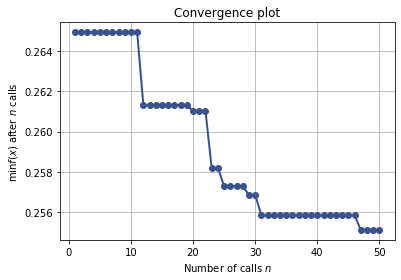

In [143]:
plot_convergence(res_gp)

Veiem com el millor model obtingut és de GradientBoostingRegressor. En quan als altres models, es veu com per molt que intentem optimitzar els paràmetres no arriba al accuracy que arriba amb GradientBoostingRegressor. Així doncs, descartem aquests 3 classificadors i ens centrem únicament amb aquest últim.

# Roc curve
La curva Roc dóna la relació entre els verdaders positius respecte la proporció de falsos positius. Com més verdeders positius respecte els falsos positius, més àrea tindrà la curva roc, i per tant millor serà la classificació.
A continuació s'avalua la classificació que fa el model GradientBoostingRegressor en funció dels falsos positius.

Primer es passa a forma binària les etiquetes de churn_risk_score per tal de poder aplicar posteriorment la curva roc

In [291]:
j = label_binarize(y, classes=[1, 2, 3, 4, 5])
n_classes = j.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X, j, test_size=.5, random_state=0)
y_score = MultiOutputRegressor(model_final).fit(X_train, y_train).predict(X_test)

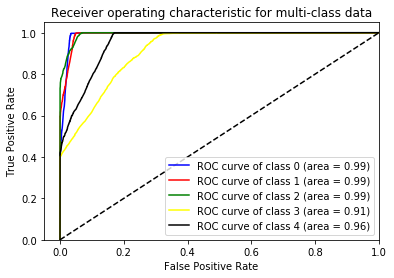

In [283]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = ['blue', 'red', 'green', 'yellow', 'black']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

Es pot veure com en general per totes les classes de 'churn_risk_score' l'àrea de la curva és molt gran, per tant es pot dir que es fa una molt bona classificació.

# Tasteig amb les dades
Ara es prediu l'etiqueta churn_risk_score amb el model més òptim que hem trobat, que és

Primer agafem els atributs més importants

In [295]:
X_test = df2_primer[['membership_category', 'feedback', 'avg_transaction_value', 'points_in_wallet']]

In [303]:
model = model_final
clf = model.fit(X, y)
pred = clf.predict(X_test)
pred = pred.round(0).astype(int)

Es mira si el resultat predit és semblant a les dades inicials. Es pot veure com és semblant, les etiquetes 1 i 2 són poc comuns respecte les altres tres.

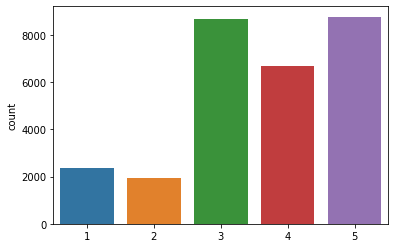

In [304]:
g = sns.countplot(pred)
g.set_xticklabels(list(set(y)))
plt.show()

# Conclusió
S'ha aconseguit un bon predictor pel dataset (90% d'encerts). Podem afirmar que es pot deduïr si un client abandonarà o no la botiga online depenent de quina categoria és, els punts que té acomulats, el valor de les transaccions que fa i els punts que té acomulats. Té sentit pensar que la fidelitat dels clients premium és superior a la dels que no tenen cap tipus de contracte, ja que si s'han fet socis és perquè realment els interessa comprar en aquella botiga, de la mateixa manera que si tenen més punts acomulats i normalment gasten més vol dir que els hi agrada l'empresa. I evidentment, si dónen un bon feedback, no abandonaran la botiga.

De cara a intentar que menys gent deixi de ser client, seria bo facilitar ser membre, donar més incentius a la compra, com els punts (sempre ajustant el necessari per obtenir el màxim benefici possible, evidentment) i tenir en conte el feedback dels clients per intentar millorar els aspectes negatius.